In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
train_path = '/content/drive/MyDrive/subband_features/train_set.csv'
val_path = '/content/drive/MyDrive/subband_features/val_set.csv'
test_path = '/content/drive/MyDrive/subband_features/test_set.csv'

***Experiment A***

*   Learning Rate = 0.001
*   Dropout Rate = 0.5
*   L2 Reg = 0.01
*   Batch Size = 32
*   Middle Blocks = 2

Epoch 1/250
110/110 - 39s - 351ms/step - accuracy: 0.5369 - loss: 4.1135 - val_accuracy: 0.5000 - val_loss: 2.5592 - learning_rate: 1.0000e-03
Epoch 2/250
110/110 - 40s - 363ms/step - accuracy: 0.6686 - loss: 2.6561 - val_accuracy: 0.5000 - val_loss: 1.7313 - learning_rate: 1.0000e-03
Epoch 3/250
110/110 - 22s - 196ms/step - accuracy: 0.8071 - loss: 1.8324 - val_accuracy: 0.5000 - val_loss: 1.3182 - learning_rate: 1.0000e-03
Epoch 4/250
110/110 - 41s - 370ms/step - accuracy: 0.8783 - loss: 1.3780 - val_accuracy: 0.5000 - val_loss: 1.1011 - learning_rate: 1.0000e-03
Epoch 5/250
110/110 - 41s - 372ms/step - accuracy: 0.9091 - loss: 1.1039 - val_accuracy: 0.5014 - val_loss: 0.9609 - learning_rate: 1.0000e-03
Epoch 6/250
110/110 - 41s - 373ms/step - accuracy: 0.9217 - loss: 0.9670 - val_accuracy: 0.7797 - val_loss: 0.7463 - learning_rate: 1.0000e-03
Epoch 7/250
110/110 - 41s - 372ms/step - accuracy: 0.9291 - loss: 0.8662 - val_accuracy: 0.9257 - val_loss: 0.5001 - learning_rate: 1.0000e-03

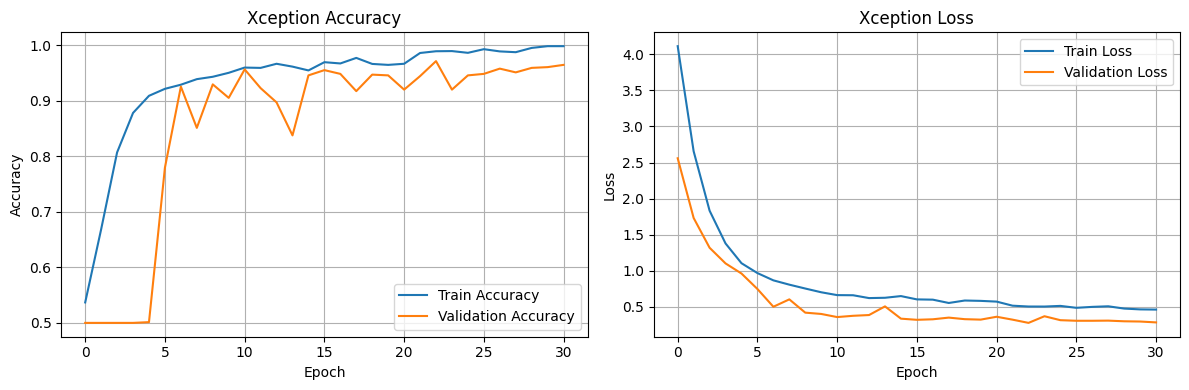

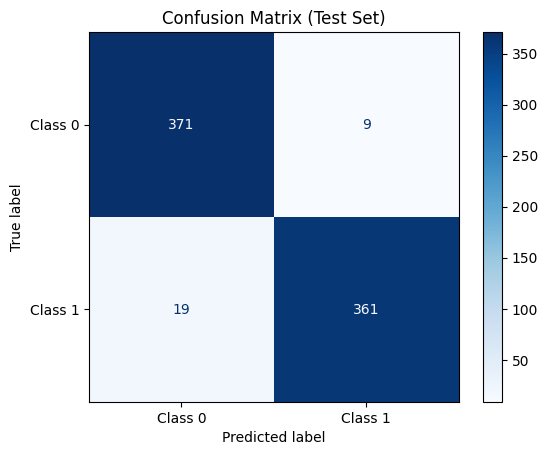

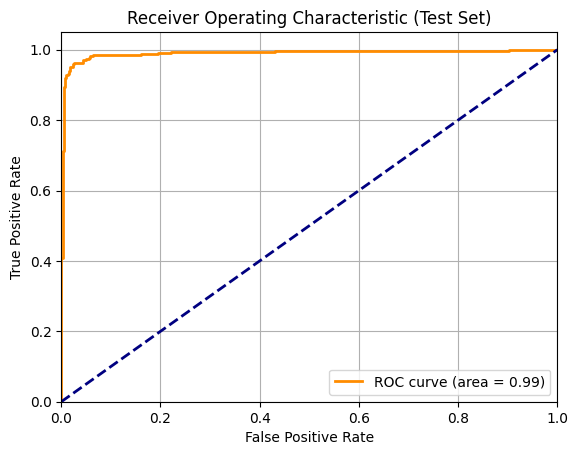

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, SeparableConv1D, BatchNormalization, Activation, MaxPooling1D, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load datasets
train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

# Drop 'file_name' and 'genre' columns
train_data = train_data.drop(['file_name', 'genre'], axis=1)
val_data = val_data.drop(['file_name', 'genre'], axis=1)
test_data = test_data.drop(['file_name', 'genre'], axis=1)

# Define feature columns
feature_columns = [col for col in train_data.columns if col != 'class']

# Extract features and labels
X_train = train_data[feature_columns].values
y_train = train_data['class'].values
X_val = val_data[feature_columns].values
y_val = val_data['class'].values
X_test = test_data[feature_columns].values
y_test = test_data['class'].values

# Shuffle training data
indices = np.random.permutation(len(X_train))
X_train = X_train[indices]
y_train = y_train[indices]

# Reshape for Conv1D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Compute class weights
class_weights = {0: 1.0 / np.mean(y_train == 0), 1: 1.0 / np.mean(y_train == 1)}

def entry_flow(x):
    x = Conv1D(32, 3, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(64, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    residual = Conv1D(128, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(128, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(128, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    residual = Conv1D(256, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    return x

def middle_flow(x, num_blocks=2):
    for _ in range(num_blocks):
        residual = x
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Add()([x, residual])
    return x

def exit_flow(x):
    residual = Conv1D(512, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(512, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(512, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    x = SeparableConv1D(728, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(1024, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    return x

# Model hyperparameters
initial_lr = 0.001
batch_size = 32
max_epochs = 250
patience = 8
dropout_rate = 0.5
kernel_regularizer = regularizers.l2(0.01)

# Build model
inputs = Input(shape=(len(feature_columns), 1))
x = entry_flow(inputs)
x = middle_flow(x, num_blocks=2)
x = exit_flow(x)
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
x = Dense(64, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
x = Dense(32, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=initial_lr),
              loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

# Train model
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    epochs=max_epochs,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Evaluate model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
y_pred = (model.predict(X_test) > 0.5).astype(int)
y_pred_proba = model.predict(X_test)

# Compute metrics
train_acc = history.history['accuracy'][-1]
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nFinal Xception Results:")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Precision (Test): {precision:.4f}")
print(f"Recall (Test): {recall:.4f}")
print(f"F1-Score (Test): {f1:.4f}")
print(f"ROC-AUC (Test): {roc_auc:.4f}")

# Accuracy & Loss Plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Xception Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Xception Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Test Set)')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Test Set)')
plt.legend(loc="lower right")
plt.grid(True)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

24/24 - 0s - 20ms/step - accuracy: 0.9632 - loss: 0.2830
Test Accuracy: 0.9632
Test Loss: 0.2830


***Experiment B***

*   Learning Rate = 0.0005
*   Dropout Rate = 0.3
*   L2 Reg = 0.01
*   Batch Size = 32
*   Middle Blocks = 2

Epoch 1/250
110/110 - 50s - 453ms/step - accuracy: 0.5591 - loss: 4.4337 - val_accuracy: 0.5000 - val_loss: 3.1759 - learning_rate: 5.0000e-04
Epoch 2/250
110/110 - 40s - 367ms/step - accuracy: 0.7257 - loss: 3.2463 - val_accuracy: 0.5000 - val_loss: 2.4140 - learning_rate: 5.0000e-04
Epoch 3/250
110/110 - 38s - 350ms/step - accuracy: 0.8294 - loss: 2.4186 - val_accuracy: 0.5000 - val_loss: 1.8999 - learning_rate: 5.0000e-04
Epoch 4/250
110/110 - 42s - 381ms/step - accuracy: 0.8729 - loss: 1.8978 - val_accuracy: 0.5000 - val_loss: 1.5624 - learning_rate: 5.0000e-04
Epoch 5/250
110/110 - 40s - 364ms/step - accuracy: 0.9097 - loss: 1.5222 - val_accuracy: 0.5000 - val_loss: 1.3437 - learning_rate: 5.0000e-04
Epoch 6/250
110/110 - 41s - 371ms/step - accuracy: 0.9314 - loss: 1.2572 - val_accuracy: 0.6595 - val_loss: 1.0748 - learning_rate: 5.0000e-04
Epoch 7/250
110/110 - 42s - 383ms/step - accuracy: 0.9391 - loss: 1.0927 - val_accuracy: 0.9216 - val_loss: 0.6886 - learning_rate: 5.0000e-04

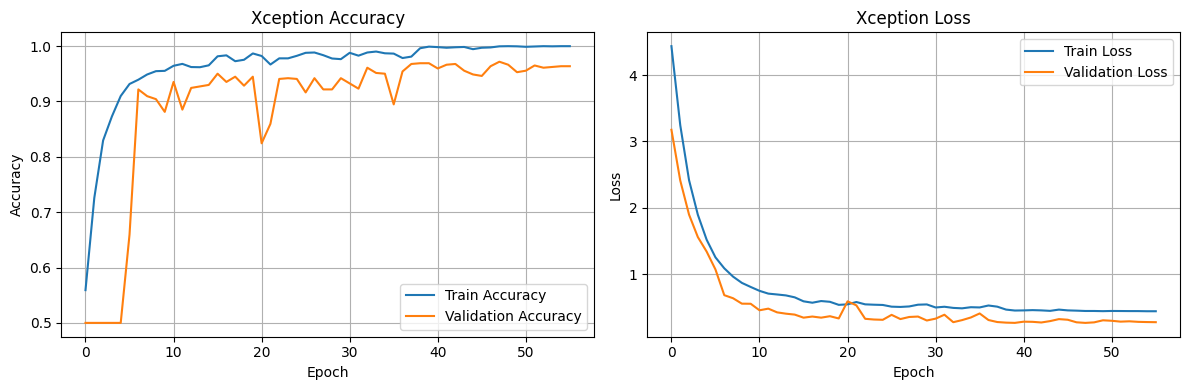

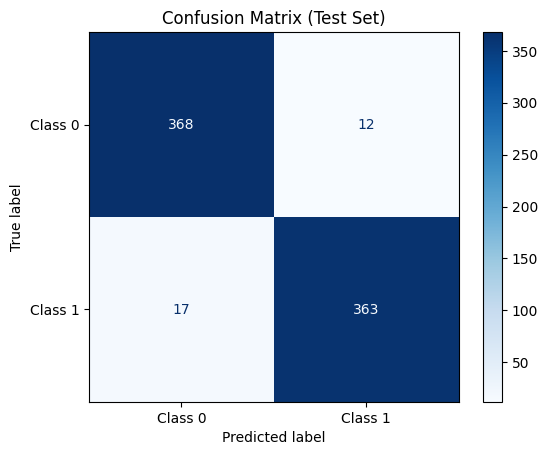

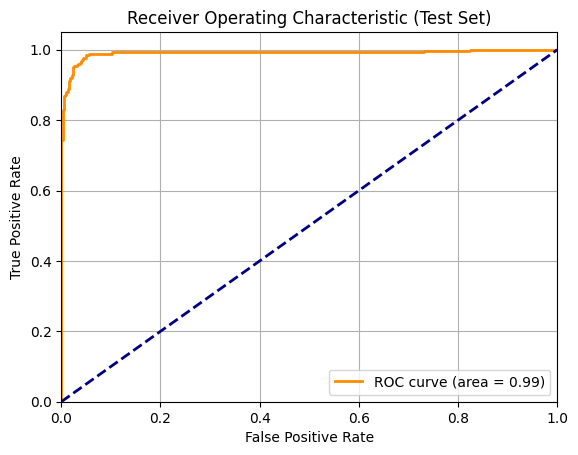

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, SeparableConv1D, BatchNormalization, Activation, MaxPooling1D, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load datasets
train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

# Drop 'file_name' and 'genre' columns
train_data = train_data.drop(['file_name', 'genre'], axis=1)
val_data = val_data.drop(['file_name', 'genre'], axis=1)
test_data = test_data.drop(['file_name', 'genre'], axis=1)

# Define feature columns
feature_columns = [col for col in train_data.columns if col != 'class']

# Extract features and labels
X_train = train_data[feature_columns].values
y_train = train_data['class'].values
X_val = val_data[feature_columns].values
y_val = val_data['class'].values
X_test = test_data[feature_columns].values
y_test = test_data['class'].values

# Shuffle training data
indices = np.random.permutation(len(X_train))
X_train = X_train[indices]
y_train = y_train[indices]

# Reshape for Conv1D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Compute class weights
class_weights = {0: 1.0 / np.mean(y_train == 0), 1: 1.0 / np.mean(y_train == 1)}

def entry_flow(x):
    x = Conv1D(32, 3, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(64, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    residual = Conv1D(128, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(128, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(128, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    residual = Conv1D(256, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    return x

def middle_flow(x, num_blocks=2):
    for _ in range(num_blocks):
        residual = x
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Add()([x, residual])
    return x

def exit_flow(x):
    residual = Conv1D(512, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(512, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(512, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    x = SeparableConv1D(728, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(1024, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    return x

# Model hyperparameters
initial_lr = 0.0005
batch_size = 32
max_epochs = 250
patience = 8
dropout_rate = 0.5
kernel_regularizer = regularizers.l2(0.01)

# Build model
inputs = Input(shape=(len(feature_columns), 1))
x = entry_flow(inputs)
x = middle_flow(x, num_blocks=2)
x = exit_flow(x)
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
x = Dense(64, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
x = Dense(32, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=initial_lr),
              loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

# Train model
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    epochs=max_epochs,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Evaluate model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
y_pred = (model.predict(X_test) > 0.5).astype(int)
y_pred_proba = model.predict(X_test)

# Compute metrics
train_acc = history.history['accuracy'][-1]
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nFinal Xception Results:")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Precision (Test): {precision:.4f}")
print(f"Recall (Test): {recall:.4f}")
print(f"F1-Score (Test): {f1:.4f}")
print(f"ROC-AUC (Test): {roc_auc:.4f}")

# Accuracy & Loss Plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Xception Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Xception Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Test Set)')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Test Set)')
plt.legend(loc="lower right")
plt.grid(True)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

24/24 - 1s - 26ms/step - accuracy: 0.9618 - loss: 0.2818
Test Accuracy: 0.9618
Test Loss: 0.2818


***Experiment C***

*   Learning Rate = 0.0005
*   Dropout Rate = 0.5
*   L2 Reg = 0.005
*   Batch Size = 64
*   Middle Blocks = 2

Epoch 1/250
110/110 - 44s - 402ms/step - accuracy: 0.5789 - loss: 4.4408 - val_accuracy: 0.5000 - val_loss: 3.2439 - learning_rate: 5.0000e-04
Epoch 2/250
110/110 - 23s - 213ms/step - accuracy: 0.7326 - loss: 3.3124 - val_accuracy: 0.5000 - val_loss: 2.5022 - learning_rate: 5.0000e-04
Epoch 3/250
110/110 - 40s - 365ms/step - accuracy: 0.8449 - loss: 2.4652 - val_accuracy: 0.5000 - val_loss: 1.9810 - learning_rate: 5.0000e-04
Epoch 4/250
110/110 - 41s - 377ms/step - accuracy: 0.8986 - loss: 1.9072 - val_accuracy: 0.5000 - val_loss: 1.6182 - learning_rate: 5.0000e-04
Epoch 5/250
110/110 - 40s - 367ms/step - accuracy: 0.9269 - loss: 1.5277 - val_accuracy: 0.5014 - val_loss: 1.3635 - learning_rate: 5.0000e-04
Epoch 6/250
110/110 - 41s - 372ms/step - accuracy: 0.9329 - loss: 1.2876 - val_accuracy: 0.9122 - val_loss: 0.9101 - learning_rate: 5.0000e-04
Epoch 7/250
110/110 - 41s - 377ms/step - accuracy: 0.9446 - loss: 1.1105 - val_accuracy: 0.9270 - val_loss: 0.6943 - learning_rate: 5.0000e-04

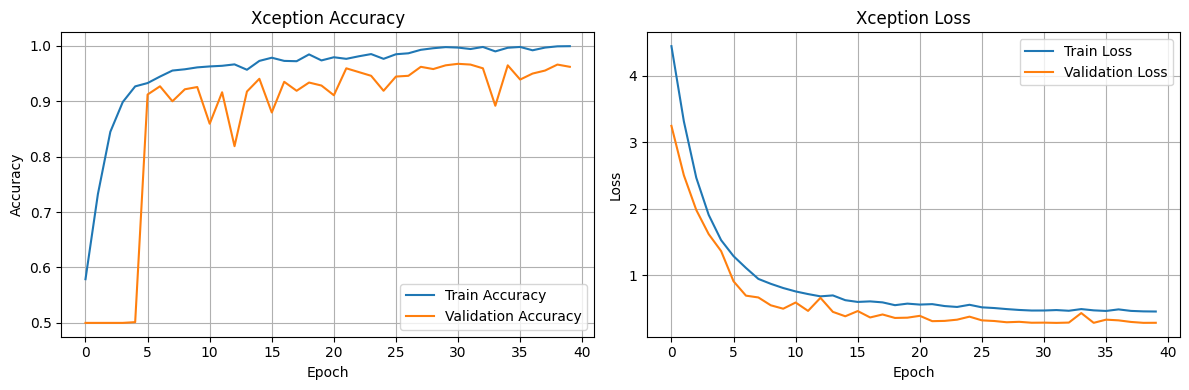

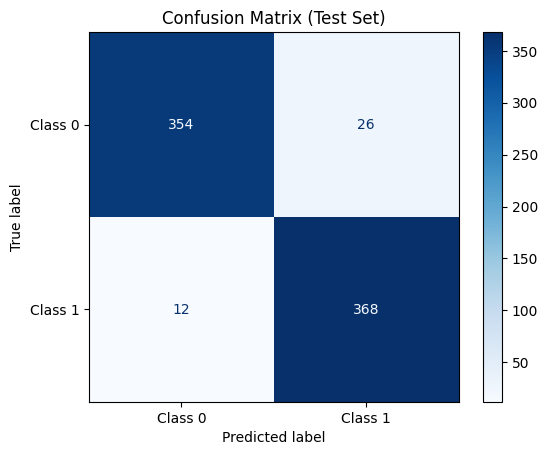

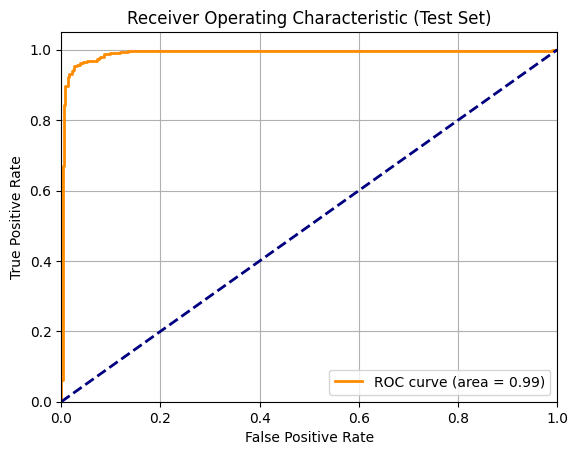

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, SeparableConv1D, BatchNormalization, Activation, MaxPooling1D, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load datasets
train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

# Drop 'file_name' and 'genre' columns
train_data = train_data.drop(['file_name', 'genre'], axis=1)
val_data = val_data.drop(['file_name', 'genre'], axis=1)
test_data = test_data.drop(['file_name', 'genre'], axis=1)

# Define feature columns
feature_columns = [col for col in train_data.columns if col != 'class']

# Extract features and labels
X_train = train_data[feature_columns].values
y_train = train_data['class'].values
X_val = val_data[feature_columns].values
y_val = val_data['class'].values
X_test = test_data[feature_columns].values
y_test = test_data['class'].values

# Shuffle training data
indices = np.random.permutation(len(X_train))
X_train = X_train[indices]
y_train = y_train[indices]

# Reshape for Conv1D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Compute class weights
class_weights = {0: 1.0 / np.mean(y_train == 0), 1: 1.0 / np.mean(y_train == 1)}

def entry_flow(x):
    x = Conv1D(32, 3, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(64, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    residual = Conv1D(128, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(128, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(128, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    residual = Conv1D(256, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    return x

def middle_flow(x, num_blocks=2):
    for _ in range(num_blocks):
        residual = x
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Add()([x, residual])
    return x

def exit_flow(x):
    residual = Conv1D(512, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(512, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(512, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    x = SeparableConv1D(728, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(1024, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    return x

# Model hyperparameters
initial_lr = 0.0005
batch_size = 32
max_epochs = 250
patience = 8
dropout_rate = 0.5
kernel_regularizer = regularizers.l2(0.01)

# Build model
inputs = Input(shape=(len(feature_columns), 1))
x = entry_flow(inputs)
x = middle_flow(x, num_blocks=2)
x = exit_flow(x)
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
x = Dense(64, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
x = Dense(32, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=initial_lr),
              loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

# Train model
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    epochs=max_epochs,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Evaluate model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
y_pred = (model.predict(X_test) > 0.5).astype(int)
y_pred_proba = model.predict(X_test)

# Compute metrics
train_acc = history.history['accuracy'][-1]
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nFinal Xception Results:")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Precision (Test): {precision:.4f}")
print(f"Recall (Test): {recall:.4f}")
print(f"F1-Score (Test): {f1:.4f}")
print(f"ROC-AUC (Test): {roc_auc:.4f}")

# Accuracy & Loss Plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Xception Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Xception Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Test Set)')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Test Set)')
plt.legend(loc="lower right")
plt.grid(True)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

24/24 - 0s - 17ms/step - accuracy: 0.9500 - loss: 0.3016
Test Accuracy: 0.9500
Test Loss: 0.3016


***Experiment E***

*   Learning Rate = 0.0003
*   Dropout Rate = 0.5
*   L2 Reg = 0.01
*   Batch Size = 32
*   Middle Blocks = 3

Epoch 1/250
110/110 - 46s - 422ms/step - accuracy: 0.5357 - loss: 4.4940 - val_accuracy: 0.5000 - val_loss: 3.2155 - learning_rate: 5.0000e-04
Epoch 2/250
110/110 - 40s - 360ms/step - accuracy: 0.7117 - loss: 3.2928 - val_accuracy: 0.5000 - val_loss: 2.4605 - learning_rate: 5.0000e-04
Epoch 3/250
110/110 - 25s - 230ms/step - accuracy: 0.7963 - loss: 2.5239 - val_accuracy: 0.5000 - val_loss: 1.9365 - learning_rate: 5.0000e-04
Epoch 4/250
110/110 - 41s - 371ms/step - accuracy: 0.8740 - loss: 1.9310 - val_accuracy: 0.5000 - val_loss: 1.5790 - learning_rate: 5.0000e-04
Epoch 5/250
110/110 - 41s - 374ms/step - accuracy: 0.9126 - loss: 1.5279 - val_accuracy: 0.6703 - val_loss: 1.2792 - learning_rate: 5.0000e-04
Epoch 6/250
110/110 - 41s - 374ms/step - accuracy: 0.9369 - loss: 1.2615 - val_accuracy: 0.8932 - val_loss: 0.9269 - learning_rate: 5.0000e-04
Epoch 7/250
110/110 - 41s - 373ms/step - accuracy: 0.9363 - loss: 1.0991 - val_accuracy: 0.8662 - val_loss: 0.7652 - learning_rate: 5.0000e-04

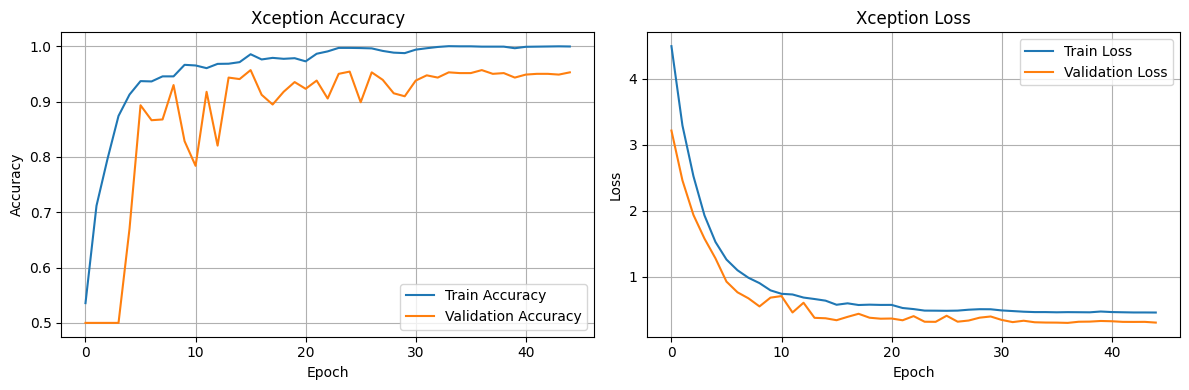

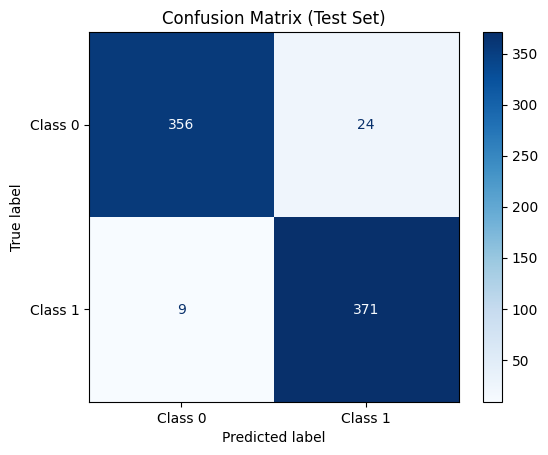

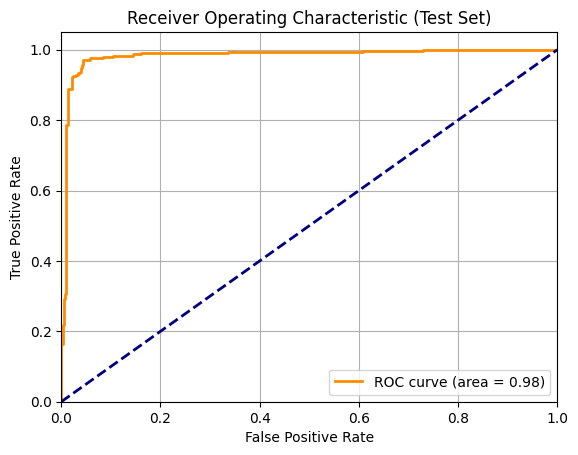

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, SeparableConv1D, BatchNormalization, Activation, MaxPooling1D, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load datasets
train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

# Drop 'file_name' and 'genre' columns
train_data = train_data.drop(['file_name', 'genre'], axis=1)
val_data = val_data.drop(['file_name', 'genre'], axis=1)
test_data = test_data.drop(['file_name', 'genre'], axis=1)

# Define feature columns
feature_columns = [col for col in train_data.columns if col != 'class']

# Extract features and labels
X_train = train_data[feature_columns].values
y_train = train_data['class'].values
X_val = val_data[feature_columns].values
y_val = val_data['class'].values
X_test = test_data[feature_columns].values
y_test = test_data['class'].values

# Shuffle training data
indices = np.random.permutation(len(X_train))
X_train = X_train[indices]
y_train = y_train[indices]

# Reshape for Conv1D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Compute class weights
class_weights = {0: 1.0 / np.mean(y_train == 0), 1: 1.0 / np.mean(y_train == 1)}

def entry_flow(x):
    x = Conv1D(32, 3, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(64, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    residual = Conv1D(128, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(128, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(128, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    residual = Conv1D(256, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    return x

def middle_flow(x, num_blocks=2):
    for _ in range(num_blocks):
        residual = x
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Add()([x, residual])
    return x

def exit_flow(x):
    residual = Conv1D(512, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(512, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(512, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    x = SeparableConv1D(728, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(1024, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    return x

# Model hyperparameters
initial_lr = 0.0005
batch_size = 32
max_epochs = 250
patience = 8
dropout_rate = 0.5
kernel_regularizer = regularizers.l2(0.01)

# Build model
inputs = Input(shape=(len(feature_columns), 1))
x = entry_flow(inputs)
x = middle_flow(x, num_blocks=2)
x = exit_flow(x)
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
x = Dense(64, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
x = Dense(32, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=initial_lr),
              loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

# Train model
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    epochs=max_epochs,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Evaluate model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
y_pred = (model.predict(X_test) > 0.5).astype(int)
y_pred_proba = model.predict(X_test)

# Compute metrics
train_acc = history.history['accuracy'][-1]
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nFinal Xception Results:")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Precision (Test): {precision:.4f}")
print(f"Recall (Test): {recall:.4f}")
print(f"F1-Score (Test): {f1:.4f}")
print(f"ROC-AUC (Test): {roc_auc:.4f}")

# Accuracy & Loss Plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Xception Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Xception Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Test Set)')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Test Set)')
plt.legend(loc="lower right")
plt.grid(True)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

24/24 - 0s - 19ms/step - accuracy: 0.9566 - loss: 0.3103
Test Accuracy: 0.9566
Test Loss: 0.3103


***Experiment F***

*   Learning Rate = 0.0007
*   Dropout Rate = 0.4
*   L2 Reg = 0.005
*   Batch Size = 32
*   Middle Blocks = 2

Epoch 1/250
110/110 - 47s - 427ms/step - accuracy: 0.5863 - loss: 2.9025 - val_accuracy: 0.5000 - val_loss: 1.9503 - learning_rate: 7.0000e-04
Epoch 2/250
110/110 - 40s - 367ms/step - accuracy: 0.7749 - loss: 2.1227 - val_accuracy: 0.5000 - val_loss: 1.5746 - learning_rate: 7.0000e-04
Epoch 3/250
110/110 - 40s - 368ms/step - accuracy: 0.8631 - loss: 1.6400 - val_accuracy: 0.5000 - val_loss: 1.3281 - learning_rate: 7.0000e-04
Epoch 4/250
110/110 - 39s - 359ms/step - accuracy: 0.9094 - loss: 1.3229 - val_accuracy: 0.6432 - val_loss: 1.1563 - learning_rate: 7.0000e-04
Epoch 5/250
110/110 - 40s - 367ms/step - accuracy: 0.9351 - loss: 1.1134 - val_accuracy: 0.5716 - val_loss: 1.0051 - learning_rate: 7.0000e-04
Epoch 6/250
110/110 - 41s - 371ms/step - accuracy: 0.9289 - loss: 1.0065 - val_accuracy: 0.9365 - val_loss: 0.6546 - learning_rate: 7.0000e-04
Epoch 7/250
110/110 - 42s - 383ms/step - accuracy: 0.9434 - loss: 0.8906 - val_accuracy: 0.9257 - val_loss: 0.5720 - learning_rate: 7.0000e-04

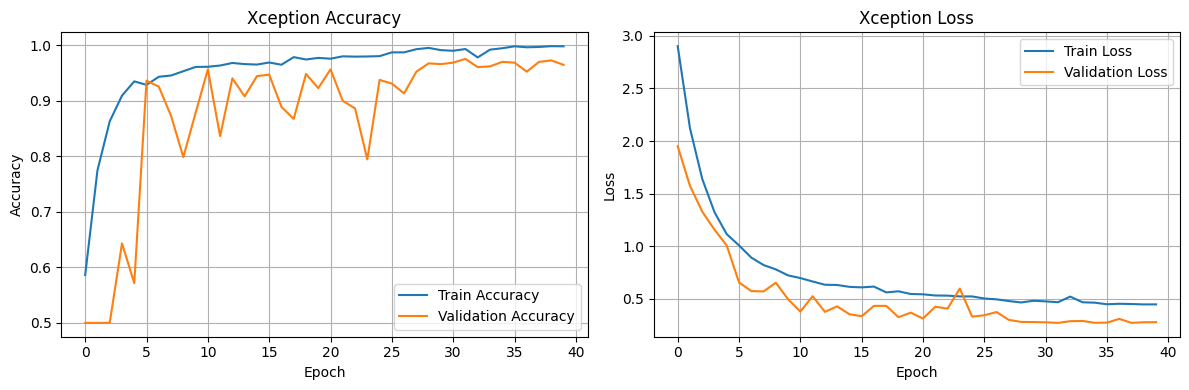

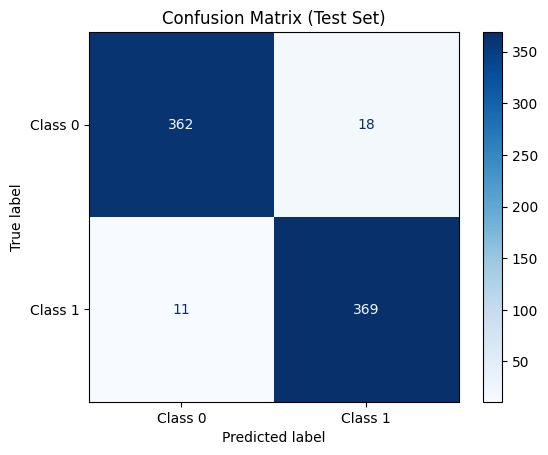

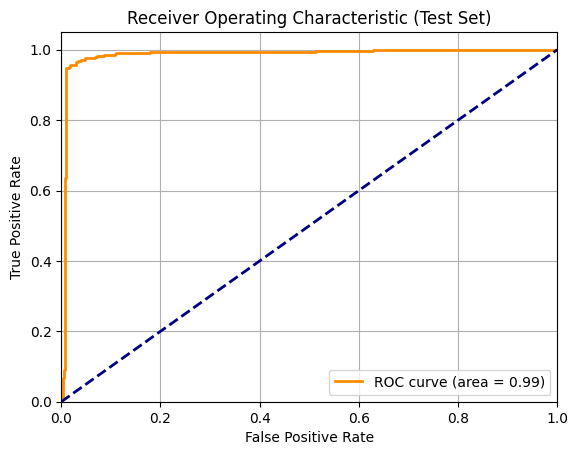

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, SeparableConv1D, BatchNormalization, Activation, MaxPooling1D, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load datasets
train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

# Drop 'file_name' and 'genre' columns
train_data = train_data.drop(['file_name', 'genre'], axis=1)
val_data = val_data.drop(['file_name', 'genre'], axis=1)
test_data = test_data.drop(['file_name', 'genre'], axis=1)

# Define feature columns
feature_columns = [col for col in train_data.columns if col != 'class']

# Extract features and labels
X_train = train_data[feature_columns].values
y_train = train_data['class'].values
X_val = val_data[feature_columns].values
y_val = val_data['class'].values
X_test = test_data[feature_columns].values
y_test = test_data['class'].values

# Shuffle training data
indices = np.random.permutation(len(X_train))
X_train = X_train[indices]
y_train = y_train[indices]

# Reshape for Conv1D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Compute class weights
class_weights = {0: 1.0 / np.mean(y_train == 0), 1: 1.0 / np.mean(y_train == 1)}

def entry_flow(x):
    x = Conv1D(32, 3, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(64, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    residual = Conv1D(128, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(128, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(128, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    residual = Conv1D(256, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    return x

def middle_flow(x, num_blocks=2):
    for _ in range(num_blocks):
        residual = x
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Add()([x, residual])
    return x

def exit_flow(x):
    residual = Conv1D(512, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(512, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(512, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    x = SeparableConv1D(728, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(1024, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    return x

# Model hyperparameters
initial_lr = 0.0007
batch_size = 32
max_epochs = 250
patience = 8
dropout_rate = 0.4
kernel_regularizer = regularizers.l2(0.005)

# Build model
inputs = Input(shape=(len(feature_columns), 1))
x = entry_flow(inputs)
x = middle_flow(x, num_blocks=2)
x = exit_flow(x)
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
x = Dense(64, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
x = Dense(32, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=initial_lr),
              loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

# Train model
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    epochs=max_epochs,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Evaluate model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
y_pred = (model.predict(X_test) > 0.5).astype(int)
y_pred_proba = model.predict(X_test)

# Compute metrics
train_acc = history.history['accuracy'][-1]
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nFinal Xception Results:")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Precision (Test): {precision:.4f}")
print(f"Recall (Test): {recall:.4f}")
print(f"F1-Score (Test): {f1:.4f}")
print(f"ROC-AUC (Test): {roc_auc:.4f}")

# Accuracy & Loss Plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Xception Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Xception Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Test Set)')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Test Set)')
plt.legend(loc="lower right")
plt.grid(True)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

24/24 - 1s - 21ms/step - accuracy: 0.9618 - loss: 0.2808
Test Accuracy: 0.9618
Test Loss: 0.2808


***Experiment G***

*   Learning Rate = 0.0005
*   Dropout Rate = 0.6
*   L2 Reg = 0.001
*   Batch Size = 16
*   Middle Blocks = 2

Epoch 1/250
219/219 - 55s - 252ms/step - accuracy: 0.5089 - loss: 1.8467 - val_accuracy: 0.5000 - val_loss: 0.9994 - learning_rate: 5.0000e-04
Epoch 2/250
219/219 - 31s - 143ms/step - accuracy: 0.5060 - loss: 1.6775 - val_accuracy: 0.5000 - val_loss: 0.9687 - learning_rate: 5.0000e-04
Epoch 3/250
219/219 - 42s - 190ms/step - accuracy: 0.4980 - loss: 1.6497 - val_accuracy: 0.5000 - val_loss: 0.9401 - learning_rate: 5.0000e-04
Epoch 4/250
219/219 - 40s - 185ms/step - accuracy: 0.4951 - loss: 1.6202 - val_accuracy: 0.5000 - val_loss: 0.9132 - learning_rate: 5.0000e-04
Epoch 5/250
219/219 - 31s - 140ms/step - accuracy: 0.5006 - loss: 1.5939 - val_accuracy: 0.5703 - val_loss: 0.8855 - learning_rate: 5.0000e-04
Epoch 6/250
219/219 - 30s - 138ms/step - accuracy: 0.5049 - loss: 1.5707 - val_accuracy: 0.4986 - val_loss: 0.8655 - learning_rate: 5.0000e-04
Epoch 7/250
219/219 - 41s - 187ms/step - accuracy: 0.5160 - loss: 1.5508 - val_accuracy: 0.5000 - val_loss: 0.8444 - learning_rate: 5.0000e-04

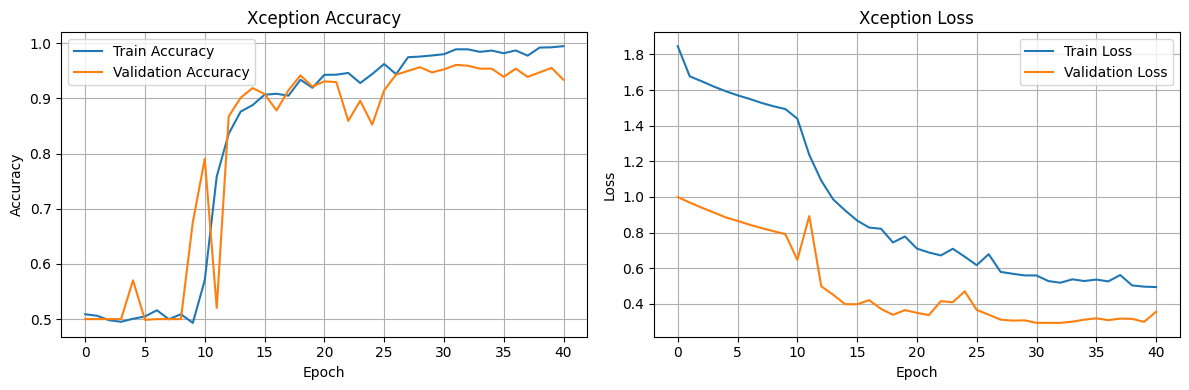

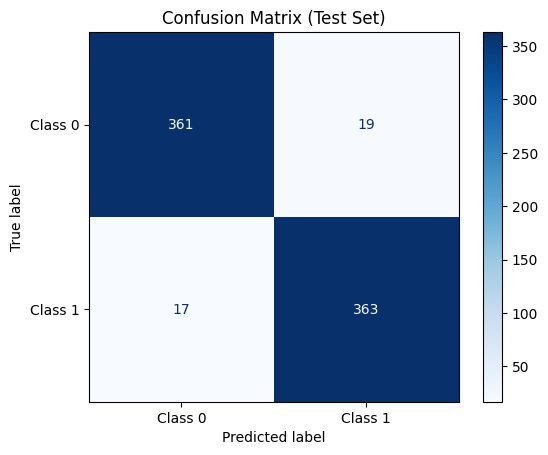

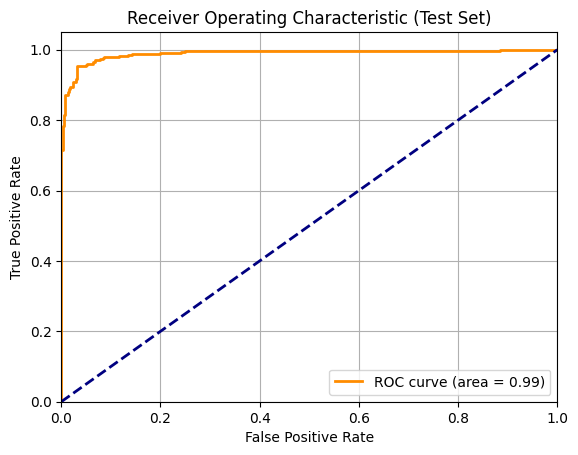

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, SeparableConv1D, BatchNormalization, Activation, MaxPooling1D, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load datasets
train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

# Drop 'file_name' and 'genre' columns
train_data = train_data.drop(['file_name', 'genre'], axis=1)
val_data = val_data.drop(['file_name', 'genre'], axis=1)
test_data = test_data.drop(['file_name', 'genre'], axis=1)

# Define feature columns
feature_columns = [col for col in train_data.columns if col != 'class']

# Extract features and labels
X_train = train_data[feature_columns].values
y_train = train_data['class'].values
X_val = val_data[feature_columns].values
y_val = val_data['class'].values
X_test = test_data[feature_columns].values
y_test = test_data['class'].values

# Shuffle training data
indices = np.random.permutation(len(X_train))
X_train = X_train[indices]
y_train = y_train[indices]

# Reshape for Conv1D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Compute class weights
class_weights = {0: 1.0 / np.mean(y_train == 0), 1: 1.0 / np.mean(y_train == 1)}

def entry_flow(x):
    x = Conv1D(32, 3, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(64, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    residual = Conv1D(128, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(128, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(128, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    residual = Conv1D(256, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    return x

def middle_flow(x, num_blocks=2):
    for _ in range(num_blocks):
        residual = x
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Add()([x, residual])
    return x

def exit_flow(x):
    residual = Conv1D(512, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(512, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(512, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    x = SeparableConv1D(728, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(1024, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    return x

# Model hyperparameters
initial_lr = 0.0005
batch_size = 16
max_epochs = 250
patience = 8
dropout_rate = 0.6
kernel_regularizer = regularizers.l2(0.001)

# Build model
inputs = Input(shape=(len(feature_columns), 1))
x = entry_flow(inputs)
x = middle_flow(x, num_blocks=2)
x = exit_flow(x)
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
x = Dense(64, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
x = Dense(32, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=initial_lr),
              loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

# Train model
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    epochs=max_epochs,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Evaluate model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
y_pred = (model.predict(X_test) > 0.5).astype(int)
y_pred_proba = model.predict(X_test)

# Compute metrics
train_acc = history.history['accuracy'][-1]
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nFinal Xception Results:")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Precision (Test): {precision:.4f}")
print(f"Recall (Test): {recall:.4f}")
print(f"F1-Score (Test): {f1:.4f}")
print(f"ROC-AUC (Test): {roc_auc:.4f}")

# Accuracy & Loss Plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Xception Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Xception Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Test Set)')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Test Set)')
plt.legend(loc="lower right")
plt.grid(True)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

24/24 - 0s - 17ms/step - accuracy: 0.9526 - loss: 0.3068
Test Accuracy: 0.9526
Test Loss: 0.3068


***Experiment H***

*   Learning Rate = 0.0005
*   Dropout Rate = 0.5
*   L2 Reg = 0.001
*   Batch Size = 32
*   Middle Blocks = 1

Epoch 1/250
110/110 - 46s - 415ms/step - accuracy: 0.5429 - loss: 1.8081 - val_accuracy: 0.5000 - val_loss: 1.0225 - learning_rate: 5.0000e-04
Epoch 2/250
110/110 - 40s - 364ms/step - accuracy: 0.7171 - loss: 1.4827 - val_accuracy: 0.5000 - val_loss: 0.9989 - learning_rate: 5.0000e-04
Epoch 3/250
110/110 - 39s - 353ms/step - accuracy: 0.8226 - loss: 1.3076 - val_accuracy: 0.5000 - val_loss: 0.9755 - learning_rate: 5.0000e-04
Epoch 4/250
110/110 - 24s - 218ms/step - accuracy: 0.8571 - loss: 1.1882 - val_accuracy: 0.7243 - val_loss: 0.9481 - learning_rate: 5.0000e-04
Epoch 5/250
110/110 - 25s - 230ms/step - accuracy: 0.8860 - loss: 1.1014 - val_accuracy: 0.6892 - val_loss: 0.8846 - learning_rate: 5.0000e-04
Epoch 6/250
110/110 - 42s - 385ms/step - accuracy: 0.9114 - loss: 1.0415 - val_accuracy: 0.8878 - val_loss: 0.6888 - learning_rate: 5.0000e-04
Epoch 7/250
110/110 - 40s - 360ms/step - accuracy: 0.9243 - loss: 0.9679 - val_accuracy: 0.9027 - val_loss: 0.6043 - learning_rate: 5.0000e-04

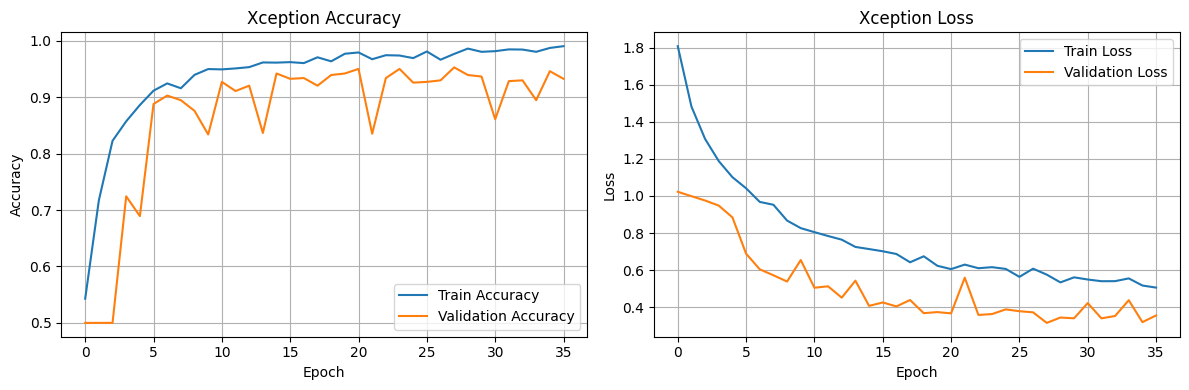

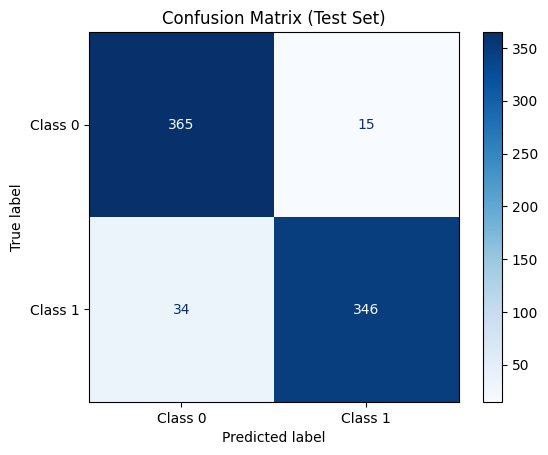

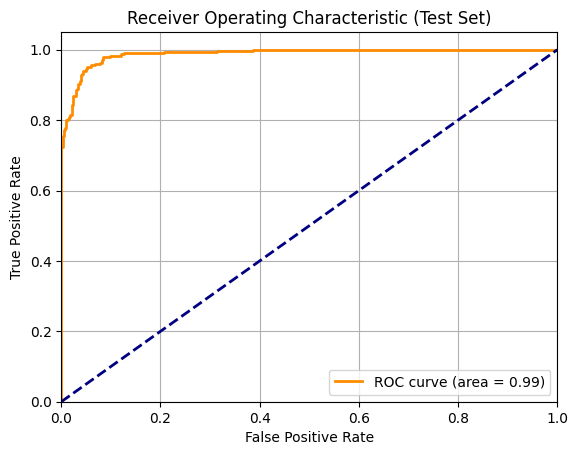

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, SeparableConv1D, BatchNormalization, Activation, MaxPooling1D, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load datasets
train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

# Drop 'file_name' and 'genre' columns
train_data = train_data.drop(['file_name', 'genre'], axis=1)
val_data = val_data.drop(['file_name', 'genre'], axis=1)
test_data = test_data.drop(['file_name', 'genre'], axis=1)

# Define feature columns
feature_columns = [col for col in train_data.columns if col != 'class']

# Extract features and labels
X_train = train_data[feature_columns].values
y_train = train_data['class'].values
X_val = val_data[feature_columns].values
y_val = val_data['class'].values
X_test = test_data[feature_columns].values
y_test = test_data['class'].values

# Shuffle training data
indices = np.random.permutation(len(X_train))
X_train = X_train[indices]
y_train = y_train[indices]

# Reshape for Conv1D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Compute class weights
class_weights = {0: 1.0 / np.mean(y_train == 0), 1: 1.0 / np.mean(y_train == 1)}

def entry_flow(x):
    x = Conv1D(32, 3, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(64, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    residual = Conv1D(128, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(128, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(128, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    residual = Conv1D(256, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    return x

def middle_flow(x, num_blocks=1):
    for _ in range(num_blocks):
        residual = x
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Add()([x, residual])
    return x

def exit_flow(x):
    residual = Conv1D(512, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(512, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(512, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    x = SeparableConv1D(728, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(1024, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    return x

# Model hyperparameters
initial_lr = 0.0005
batch_size = 32
max_epochs = 250
patience = 8
dropout_rate = 0.5
kernel_regularizer = regularizers.l2(0.001)

# Build model
inputs = Input(shape=(len(feature_columns), 1))
x = entry_flow(inputs)
x = middle_flow(x, num_blocks=2)
x = exit_flow(x)
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
x = Dense(64, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
x = Dense(32, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=initial_lr),
              loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

# Train model
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    epochs=max_epochs,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Evaluate model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
y_pred = (model.predict(X_test) > 0.5).astype(int)
y_pred_proba = model.predict(X_test)

# Compute metrics
train_acc = history.history['accuracy'][-1]
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nFinal Xception Results:")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Precision (Test): {precision:.4f}")
print(f"Recall (Test): {recall:.4f}")
print(f"F1-Score (Test): {f1:.4f}")
print(f"ROC-AUC (Test): {roc_auc:.4f}")

# Accuracy & Loss Plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Xception Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Xception Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Test Set)')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Test Set)')
plt.legend(loc="lower right")
plt.grid(True)

In [4]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

24/24 - 0s - 18ms/step - accuracy: 0.9355 - loss: 0.3375
Test Accuracy: 0.9355
Test Loss: 0.3375


***Experiment I***

*   Learning Rate = 0.0002
*   Dropout Rate = 0.4
*   L2 Reg = 0.0005
*   Batch Size = 32
*   Middle Blocks = 2

Epoch 1/250
110/110 - 47s - 427ms/step - accuracy: 0.5743 - loss: 1.5573 - val_accuracy: 0.5000 - val_loss: 0.8671 - learning_rate: 2.0000e-04
Epoch 2/250
110/110 - 39s - 353ms/step - accuracy: 0.7377 - loss: 1.3118 - val_accuracy: 0.5000 - val_loss: 0.8641 - learning_rate: 2.0000e-04
Epoch 3/250
110/110 - 28s - 250ms/step - accuracy: 0.8211 - loss: 1.1341 - val_accuracy: 0.5000 - val_loss: 0.8614 - learning_rate: 2.0000e-04
Epoch 4/250
110/110 - 40s - 362ms/step - accuracy: 0.8800 - loss: 0.9971 - val_accuracy: 0.5000 - val_loss: 0.8588 - learning_rate: 2.0000e-04
Epoch 5/250
110/110 - 43s - 391ms/step - accuracy: 0.9166 - loss: 0.9248 - val_accuracy: 0.5000 - val_loss: 0.8483 - learning_rate: 2.0000e-04
Epoch 6/250
110/110 - 40s - 360ms/step - accuracy: 0.9160 - loss: 0.8920 - val_accuracy: 0.7351 - val_loss: 0.6958 - learning_rate: 2.0000e-04
Epoch 7/250
110/110 - 25s - 227ms/step - accuracy: 0.9457 - loss: 0.8125 - val_accuracy: 0.7027 - val_loss: 0.8075 - learning_rate: 2.0000e-04

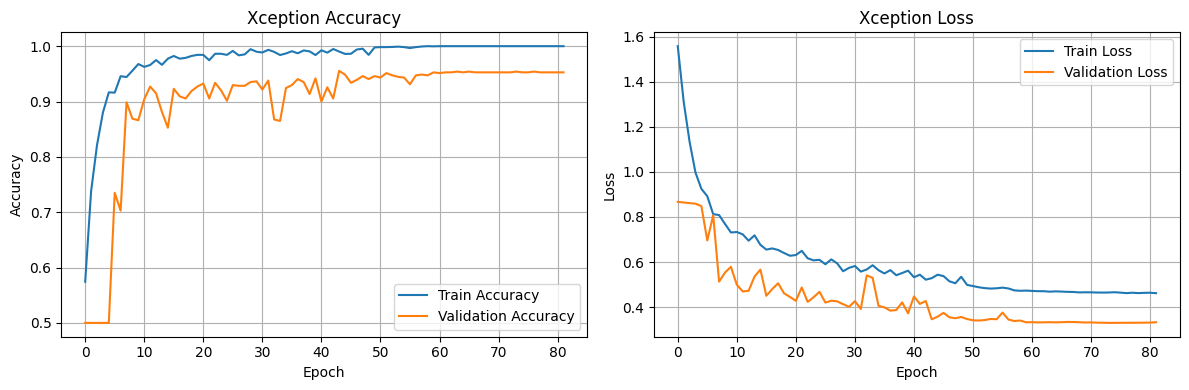

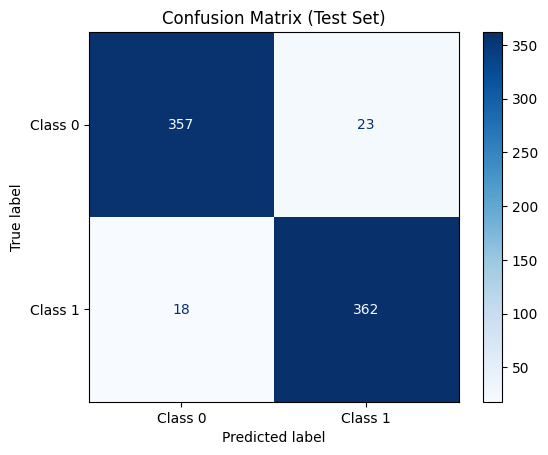

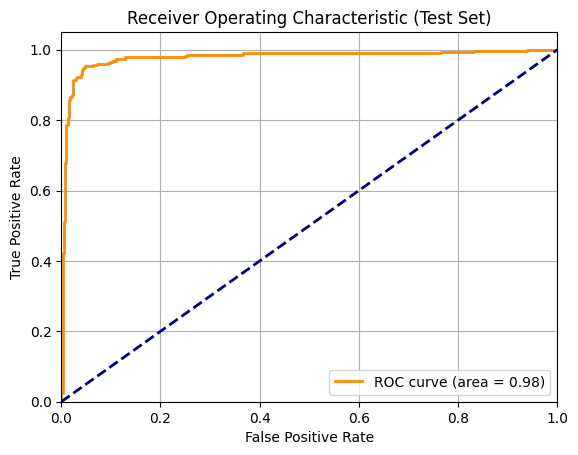

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, SeparableConv1D, BatchNormalization, Activation, MaxPooling1D, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load datasets
train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

# Drop 'file_name' and 'genre' columns
train_data = train_data.drop(['file_name', 'genre'], axis=1)
val_data = val_data.drop(['file_name', 'genre'], axis=1)
test_data = test_data.drop(['file_name', 'genre'], axis=1)

# Define feature columns
feature_columns = [col for col in train_data.columns if col != 'class']

# Extract features and labels
X_train = train_data[feature_columns].values
y_train = train_data['class'].values
X_val = val_data[feature_columns].values
y_val = val_data['class'].values
X_test = test_data[feature_columns].values
y_test = test_data['class'].values

# Shuffle training data
indices = np.random.permutation(len(X_train))
X_train = X_train[indices]
y_train = y_train[indices]

# Reshape for Conv1D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Compute class weights
class_weights = {0: 1.0 / np.mean(y_train == 0), 1: 1.0 / np.mean(y_train == 1)}

def entry_flow(x):
    x = Conv1D(32, 3, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(64, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    residual = Conv1D(128, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(128, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(128, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    residual = Conv1D(256, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    return x

def middle_flow(x, num_blocks=2):
    for _ in range(num_blocks):
        residual = x
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Add()([x, residual])
    return x

def exit_flow(x):
    residual = Conv1D(512, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(512, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(512, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    x = SeparableConv1D(728, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(1024, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    return x

# Model hyperparameters
initial_lr = 0.0002
batch_size = 32
max_epochs = 250
patience = 8
dropout_rate = 0.4
kernel_regularizer = regularizers.l2(0.0005)

# Build model
inputs = Input(shape=(len(feature_columns), 1))
x = entry_flow(inputs)
x = middle_flow(x, num_blocks=2)
x = exit_flow(x)
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
x = Dense(64, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
x = Dense(32, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=initial_lr),
              loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

# Train model
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    epochs=max_epochs,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Evaluate model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
y_pred = (model.predict(X_test) > 0.5).astype(int)
y_pred_proba = model.predict(X_test)

# Compute metrics
train_acc = history.history['accuracy'][-1]
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nFinal Xception Results:")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Precision (Test): {precision:.4f}")
print(f"Recall (Test): {recall:.4f}")
print(f"F1-Score (Test): {f1:.4f}")
print(f"ROC-AUC (Test): {roc_auc:.4f}")

# Accuracy & Loss Plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Xception Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Xception Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Test Set)')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Test Set)')
plt.legend(loc="lower right")
plt.grid(True)

In [4]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

24/24 - 0s - 18ms/step - accuracy: 0.9461 - loss: 0.3450
Test Accuracy: 0.9461
Test Loss: 0.3450


***Experiment J***

*   Learning Rate = 0.0005
*   Dropout Rate = 0.5
*   L2 Reg = 0.001
*   Batch Size = 32
*   Middle Blocks = 4

Epoch 1/250
110/110 - 48s - 438ms/step - accuracy: 0.5203 - loss: 1.8275 - val_accuracy: 0.5000 - val_loss: 1.0213 - learning_rate: 5.0000e-04
Epoch 2/250
110/110 - 40s - 364ms/step - accuracy: 0.6203 - loss: 1.6390 - val_accuracy: 0.5000 - val_loss: 0.9978 - learning_rate: 5.0000e-04
Epoch 3/250
110/110 - 41s - 376ms/step - accuracy: 0.7280 - loss: 1.4583 - val_accuracy: 0.5000 - val_loss: 0.9761 - learning_rate: 5.0000e-04
Epoch 4/250
110/110 - 40s - 361ms/step - accuracy: 0.7874 - loss: 1.3205 - val_accuracy: 0.5000 - val_loss: 0.9548 - learning_rate: 5.0000e-04
Epoch 5/250
110/110 - 42s - 379ms/step - accuracy: 0.8523 - loss: 1.1914 - val_accuracy: 0.7378 - val_loss: 0.9039 - learning_rate: 5.0000e-04
Epoch 6/250
110/110 - 40s - 368ms/step - accuracy: 0.8789 - loss: 1.0918 - val_accuracy: 0.8446 - val_loss: 0.7326 - learning_rate: 5.0000e-04
Epoch 7/250
110/110 - 25s - 231ms/step - accuracy: 0.8971 - loss: 1.0504 - val_accuracy: 0.8203 - val_loss: 0.6733 - learning_rate: 5.0000e-04

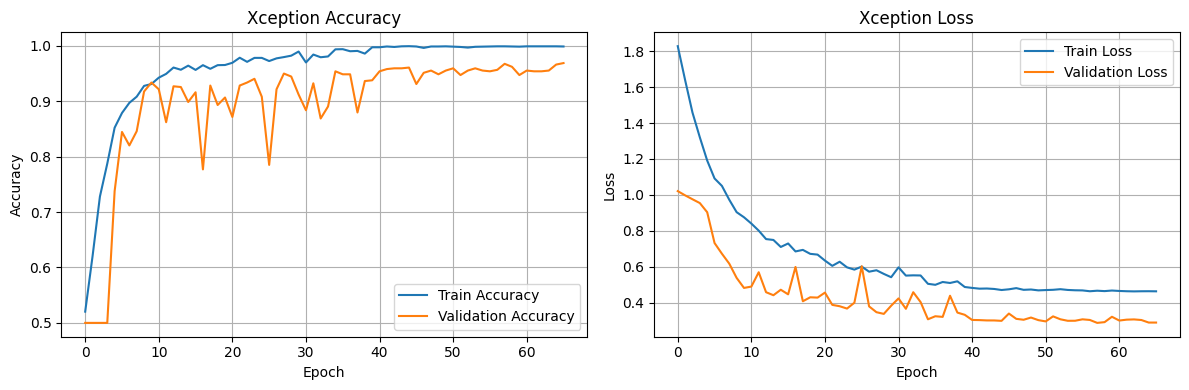

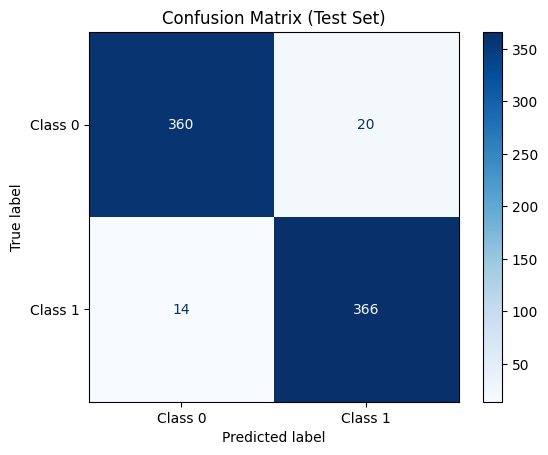

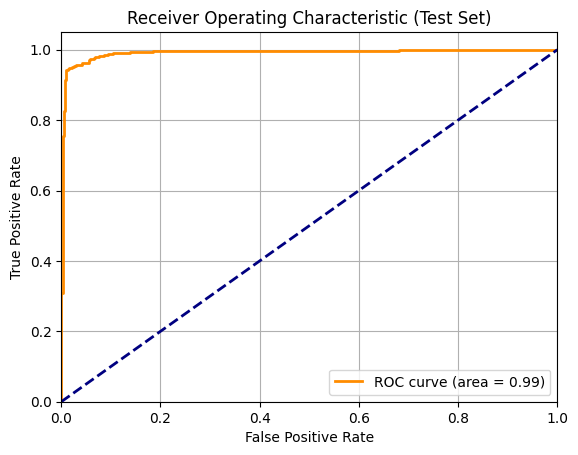

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, SeparableConv1D, BatchNormalization, Activation, MaxPooling1D, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load datasets
train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

# Drop 'file_name' and 'genre' columns
train_data = train_data.drop(['file_name', 'genre'], axis=1)
val_data = val_data.drop(['file_name', 'genre'], axis=1)
test_data = test_data.drop(['file_name', 'genre'], axis=1)

# Define feature columns
feature_columns = [col for col in train_data.columns if col != 'class']

# Extract features and labels
X_train = train_data[feature_columns].values
y_train = train_data['class'].values
X_val = val_data[feature_columns].values
y_val = val_data['class'].values
X_test = test_data[feature_columns].values
y_test = test_data['class'].values

# Shuffle training data
indices = np.random.permutation(len(X_train))
X_train = X_train[indices]
y_train = y_train[indices]

# Reshape for Conv1D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Compute class weights
class_weights = {0: 1.0 / np.mean(y_train == 0), 1: 1.0 / np.mean(y_train == 1)}

def entry_flow(x):
    x = Conv1D(32, 3, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(64, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    residual = Conv1D(128, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(128, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(128, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    residual = Conv1D(256, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    return x

def middle_flow(x, num_blocks=4):
    for _ in range(num_blocks):
        residual = x
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv1D(256, 3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Add()([x, residual])
    return x

def exit_flow(x):
    residual = Conv1D(512, 1, strides=2, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(512, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(512, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    x = Add()([x, residual])
    x = SeparableConv1D(728, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv1D(1024, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2, strides=2, padding='same')(x)
    return x

# Model hyperparameters
initial_lr = 0.0005
batch_size = 32
max_epochs = 250
patience = 8
dropout_rate = 0.5
kernel_regularizer = regularizers.l2(0.001)

# Build model
inputs = Input(shape=(len(feature_columns), 1))
x = entry_flow(inputs)
x = middle_flow(x, num_blocks=2)
x = exit_flow(x)
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
x = Dense(64, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
x = Dense(32, activation='relu', kernel_regularizer=kernel_regularizer)(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=initial_lr),
              loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

# Train model
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    epochs=max_epochs,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Evaluate model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
y_pred = (model.predict(X_test) > 0.5).astype(int)
y_pred_proba = model.predict(X_test)

# Compute metrics
train_acc = history.history['accuracy'][-1]
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nFinal Xception Results:")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Precision (Test): {precision:.4f}")
print(f"Recall (Test): {recall:.4f}")
print(f"F1-Score (Test): {f1:.4f}")
print(f"ROC-AUC (Test): {roc_auc:.4f}")

# Accuracy & Loss Plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Xception Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Xception Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Test Set)')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Test Set)')
plt.legend(loc="lower right")
plt.grid(True)

In [4]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

24/24 - 0s - 19ms/step - accuracy: 0.9553 - loss: 0.2973
Test Accuracy: 0.9553
Test Loss: 0.2973
